# 타이타닉 생존자 ML 예측 구현
    1. 데이터 전처리
        - null 처리
        - 불필요한 속성 제거
        - 인코딩 수행
    2. 모델 학습 및 검증/예측/평가
        - 결정트리, 랜덤포레스트, 로지스틱 회귀 학습 비교
        - K 폴드 교차검증
        - cross_val_score()와 GridSearchCV() 수행

# 2장 Summary
    - 머신러닝 지도학습 프로세스
        1. 데이터 전처리
            - 데이터 클린징
            - 결손값 처리 (Null/NaN 처리)
            - 데이터 인코딩 (Label, One-Hot Encoding)
            - 데이터 스케일링
            - 이상치 제거
            - Feature 선택, 추출 및 가공
        ============================================= 교차 검증, cross_val_score(), GridSearchCV==========================
        2. 데이터 셋 분리
            - 학습 데이터/테스트 데이터 분리
        3. 모델 학습 및 검증 평가
            - 알고리즘 학습
        ==================================================================================================================
        4. 예측 수행
            - 테스트 데이터로 예측 수행
        5. 평가
            - 예측 평가

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

titanic_df = pd.read_csv('D:/kaggle/titanic/train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


- PassengerId: 탑승자 데이터 일련번호
- survived: 생존 여부, 0=사망, 1=생존
- Pclass: 티켓의 선실 등급, 1=일등석, 2=이등석, 3=삼등석
- sex: 탑승자 성별
- name: 탑승자 이름
- Age: 탑승자 나이
- sibsp: 같이 탑승한 형제자매 또는 배우자 인원수
- parch: 같이 탑승한 부모님 또는 어린이 인원수
- ticket: 티켓 번호
- fare: 요금
- cabin: 선실 번호
- embarked: 중간 정착 항구 C=Cherbourg, Q=Queenstown, S=Southampton

In [4]:
print("\n ### train 데이터 정보 ### \n")
print(titanic_df.info())


 ### train 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


#### NULL 컬럼들에 대한 처리

In [6]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)

print(titanic_df.isna().sum())
print("데이터셋 null값 갯수: ", titanic_df.isna().sum().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64
데이터셋 null값 갯수:  0


In [7]:
print("Sex값 분포: \n", titanic_df['Sex'].value_counts())
print("\n Cabin값 분포: \n", titanic_df['Cabin'].value_counts())
print("\n Embarked값 분포: \n", titanic_df['Embarked'].value_counts())

Sex값 분포: 
 male      577
female    314
Name: Sex, dtype: int64

 Cabin값 분포: 
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
F2               3
              ... 
A6               1
D56              1
D45              1
C62 C64          1
D49              1
Name: Cabin, Length: 148, dtype: int64

 Embarked값 분포: 
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [9]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))
titanic_df['Cabin'].value_counts()

0    N
1    C
2    N
Name: Cabin, dtype: object


N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

In [10]:
titanic_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

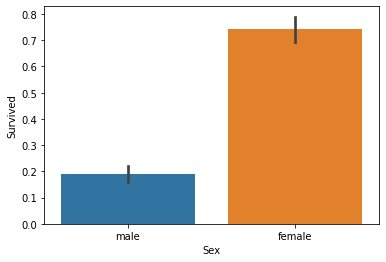

In [11]:
sns.barplot(x="Sex", y="Survived", data=titanic_df)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

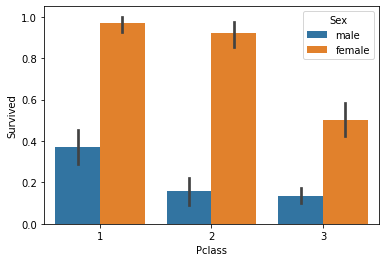

In [13]:
# hue에 대한 column도 같이 비교
sns.barplot(x='Pclass', y='Survived', hue="Sex", data=titanic_df)

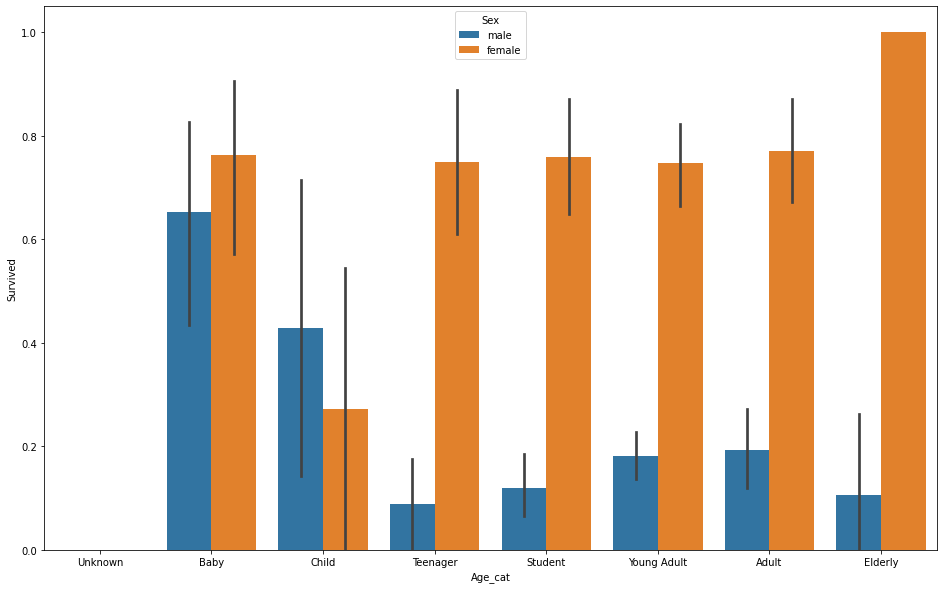

In [14]:
# 입력 age에 따라 구분 값을 반환하는 함수 설정
# DataFrame의 apply lambda식에 사용

def get_category(age):
    cat = ""
    if age <= -1: cat= "Unknown"
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else: cat = 'Elderly'
            
    return cat

# 막대그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(16,10))

# X축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda식에 위에서 생성한 get_category() 함수를 반환값으로 지정
# get_category(X)는 입력값으로 'Age' 컬럼값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x: get_category(x))
sns.barplot(x="Age_cat", y="Survived", hue="Sex", data=titanic_df, order=group_names)
titanic_df.drop("Age_cat", axis=1, inplace=True)

In [15]:
from sklearn import preprocessing

def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


In [18]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [19]:
# 원본 데이터를 재로딩하고 feature 데이터 셋과 Label 데이터 셋 추출
titanic_df = pd.read_csv('D:/kaggle/titanic/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

X_titanic_df = transform_features(X_titanic_df)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print("DT 정확도: {0:.4f}".format(accuracy_score(y_test,dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print("RF 정확도: {0:.4f}".format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
print("LR 정확도: {0:.4f}".format(accuracy_score(y_test, lr_pred)))

DT 정확도: 0.7877
RF 정확도: 0.8547
LR 정확도: 0.8492


c:\pythonproject\workspace\venv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    # 폴드 셋을 5개인 KFold 객체 생성, 폴드 수만큼 예측결과 저장을 위한 리스트 객체 생성
    kfold = KFold(n_splits=folds)
    scores = []
    
    # KFold 교차 검증 수행
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        
        # Classifier 학습, 예측, 정확도 계산
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
        
    # 5개 fold에서의 평균 정확도 계산
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score))
    
# exec_kfold 호출
exec_kfold(dt_clf, folds=5)

교차검증 0 정확도: 0.7542
교차검증 1 정확도: 0.7809
교차검증 2 정확도: 0.7865
교차검증 3 정확도: 0.7697
교차검증 4 정확도: 0.8202
평균 정확도: 0.7823


In [26]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth':[2,3,5,10],
         'min_samples_split':[2,3,5],
         'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print("GridSearchCV 최적 하이퍼 파라미터: ", grid_dclf.best_params_)
print("GridSearchCV 최고 정확도: {0:.4f}".format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print("test셋에서의 DT 정확도: {0:.4f}".format(accuracy))

GridSearchCV 최적 하이퍼 파라미터:  {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
test셋에서의 DT 정확도: 0.8715
